In [5]:
# %load Final_Model_Submission.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
from sklearn.feature_selection import f_classif,SelectKBest
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

In [7]:

# Initialising

# This section handles the generic initialisation of maximum rows and columns to be displayed when executed
# This section also sets the path for the datasets

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
os.chdir('/Users/praveenthenraj/Desktop/PycharmProjects/Trial/Hackerearth/Novartis/Data/Dataset')


# Reading the data

# This section handles reading the train,test,and sample submission file and creating respective dataframes

train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')
sample=pd.read_csv('sample_submission.csv')
submis=pd.DataFrame()


# Initialising Variables and Data Structures

# This section handles the initialisation of an empty list for storing the important features identified later

imp_feature=[]


In [8]:

# Basic Health Checks

# This section performs the basic health checks on the train and test dataframes:

print('Training Data Shape : '+str(train.shape)+'\n')                                                           #(23856, 18)
print('Testing Data Shape  : '+str(test.shape)+'\n')                                                            #(15903, 17)
print('Training Data Non-int type : '+'\n'+'\n'+str(train.dtypes!=np.int64)+'\n')                               #INCIDENT_ID,DATE,X_12
print('Testing Data Non-int type : '+'\n'+'\n'+str(test.dtypes!=np.int64)+'\n')                                 #INCIDENT_ID,DATE,X_12
print('Training Data Null Columns : '+'\n'+'\n'+str(train.isna().any())+'\n')                                   #X_12
print('Testing Data Null Columns : '+'\n'+'\n'+str(test.isna().any())+'\n')                                     #X_12
print('Count of Null Data in Train : '+'\n'+'\n'+str(train.isna().sum())+'\n')                                  #182
print('Count of Null Data in Test : '+'\n'+'\n'+str(test.isna().sum())+'\n')                                    #127
print('Balance of Dependant Variables : '+'\n'+'\n'+str(train['MULTIPLE_OFFENSE'].value_counts())+'\n')         #0-1068 1-22788
print('No of duplicates in Train Data : '+str(len(train.loc[train['INCIDENT_ID'].duplicated()]==True))+'\n')
print('No of duplicates in Train Data : '+str(len(test.loc[test['INCIDENT_ID'].duplicated()]==True))+'\n')
print('IQR for feature X_12 : '+str(train.describe()))                                                         #0.9740
print('IQR for feature X_12 : '+str(test.describe()))                                                          #0.9722


Training Data Shape : (23856, 18)

Testing Data Shape  : (15903, 17)

Training Data Non-int type : 

INCIDENT_ID          True
DATE                 True
X_1                 False
X_2                 False
X_3                 False
X_4                 False
X_5                 False
X_6                 False
X_7                 False
X_8                 False
X_9                 False
X_10                False
X_11                False
X_12                 True
X_13                False
X_14                False
X_15                False
MULTIPLE_OFFENSE    False
dtype: bool

Testing Data Non-int type : 

INCIDENT_ID     True
DATE            True
X_1            False
X_2            False
X_3            False
X_4            False
X_5            False
X_6            False
X_7            False
X_8            False
X_9            False
X_10           False
X_11           False
X_12            True
X_13           False
X_14           False
X_15           False
dtype: bool

Training Data Null

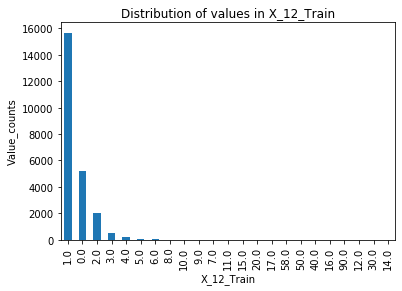

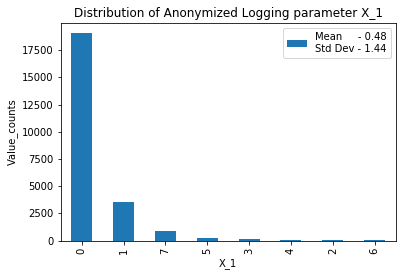

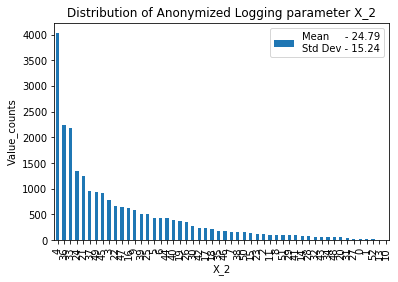

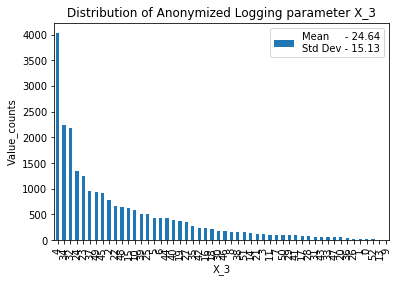

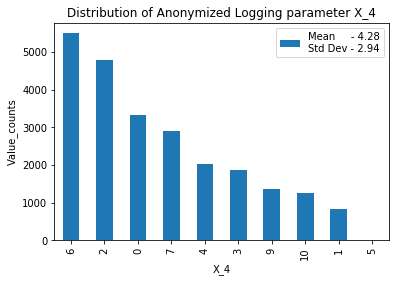

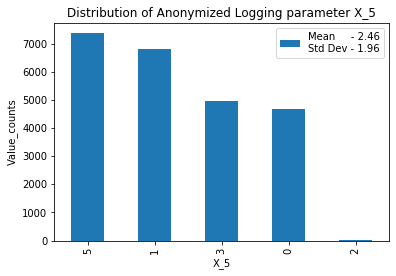

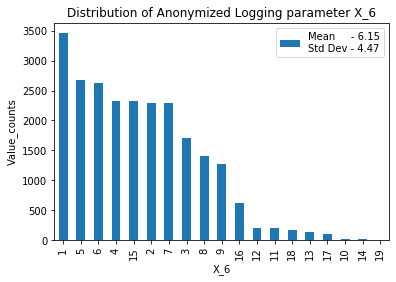

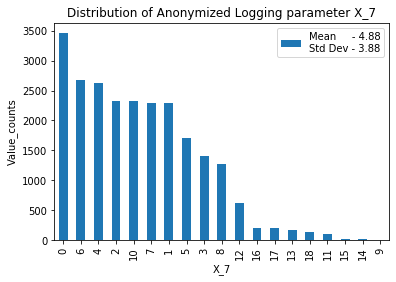

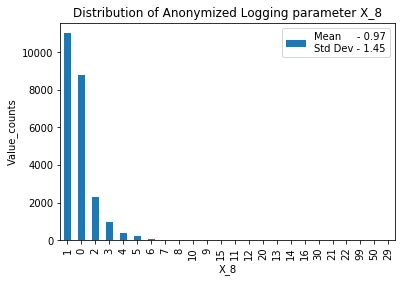

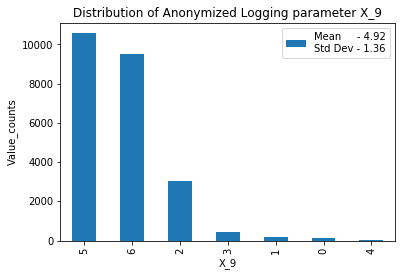

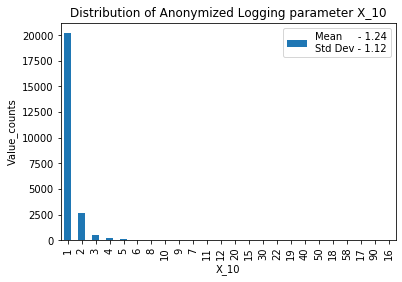

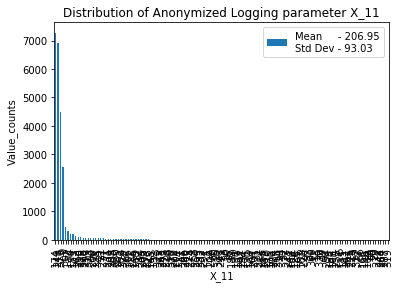

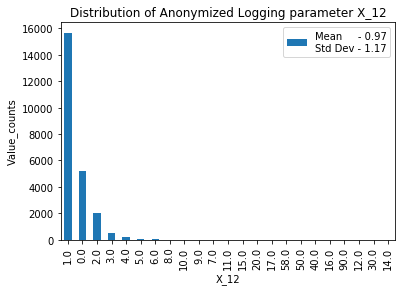

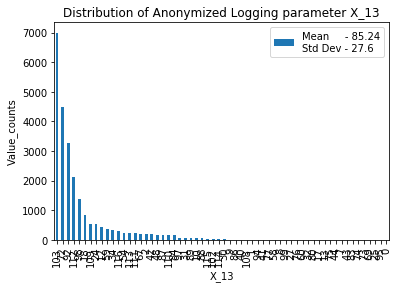

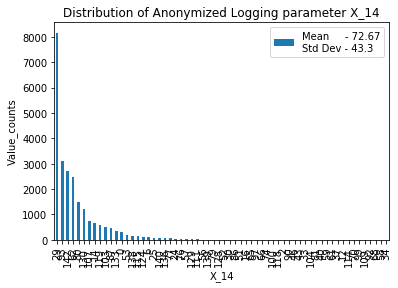

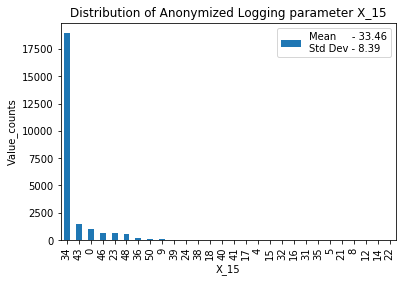

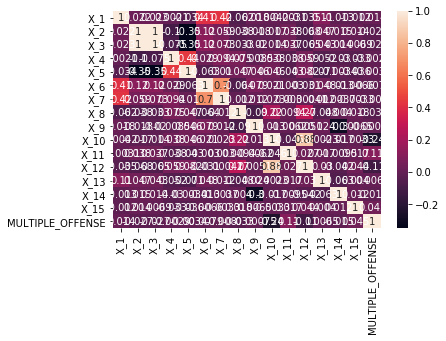

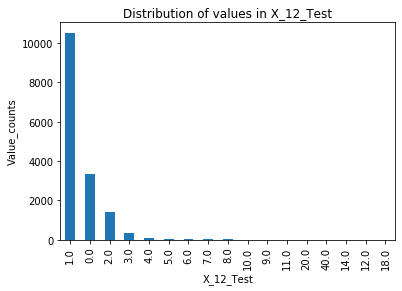

In [9]:
# EDA

# This section is used to create the EDA for the given datasets

# Plot 1: To identify the distribution of values in X_12 feature to impute for NaN values in train data:
# From the plot, it can be seen that 90% of X_12 value in train_data has value of 1

train['X_12'].value_counts().plot(kind='bar')
plt.xlabel('X_12_Train')
plt.ylabel('Value_counts')
plt.title('Distribution of values in X_12_Train')
plt.show()


# Plot 2: To identify the distribution of each predictor variable and their respective mean and std deviation
# This plot helps to identify the scaling range of each features

train_eda = train.iloc[:, 2:17]

for i in train_eda.columns:
    std = np.round(np.std(train[i]), 2)
    mean = np.round(np.mean(train[i]), 2)
    train[i].value_counts().plot(kind='bar',label=r'Mean    ' + ' - ' + str(mean) + '\n' + r'Std Dev' + ' - ' + str(std))
    plt.xlabel(i)
    plt.ylabel('Value_counts')
    plt.legend()
    plt.title('Distribution of Anonymized Logging parameter ' + i)
    plt.show()


# Plot 3: To identify the correlation between the various dependant variables
# This plots helps to identify the features with multicollinearity. This helps in identifying and dropping those
# features which are highly correlated.

sns.heatmap(train.corr(), annot=True)
plt.show()

# From the above plot it can be seen that the following pairs are highly correlated with each other and hence
# both features can be dropped in case of low variance test score(which will be done later below) or either
# feature will be dropped in case of high variance test score.

# (X_2,X_3)   - correlation of 1 (multicollinear)
# (X_10,X_12) - correlation of 0.88 (multicollinear)


# Plot 4: To identify the distribution of values in X_12 feature to impute for NaN values in test data:
# From the plot, it can be seen that the distribution in test data is similar to the train data and most
# value is 1

test['X_12'].value_counts().plot(kind='bar')
plt.xlabel('X_12_Test')
plt.ylabel('Value_counts')
plt.title('Distribution of values in X_12_Test')
plt.show()


In [10]:

# Feature Preprocessing and Feature Transformation:

# This section handles preprocessing of the input dataset like filling the missing values.
# From the given datasets it is found that only feature X_12 has missing values in both train and test dataset.
# Filling the na values with 1 as Plot_1 suggested that X_12 has maximum number of values as 1 and also a
# mean of values in X_12 in train and test data is 0.9740 and 0.9722 respectively
# We are considering mean to fill Nan values, because from plot1 and plot 4 we can see that the distribution
# of data in feature X_12 is right skewed. Considering the central tendency measure mean for
# such distributions is a better approach.


def feature_preprocess_transformation(data):
    global train,test
    data['X_12']=data['X_12'].fillna(value=1.0).astype(int)                                                    


# Calling the preprocessing function for Train and Test Data
# Functions to fill the missing values in train and test dataset

feature_preprocess_transformation(train)
feature_preprocess_transformation(test)


In [11]:

# Feature Importance and Train_Test Data Split
# This section handles identifying the important features and splitting the training data as train_test split
# to train and validate the model

# Here the feature incident_id has been dropped because it does not hold any cause for the cyber attack.
# The feature MULTIPLE_OFFENSE has been dropped as it is the target variable

indep=train.drop(['INCIDENT_ID','DATE','MULTIPLE_OFFENSE'],axis=1).values
dep=train['MULTIPLE_OFFENSE'].values


# Here we are doing an ANNOVA TEST to identify the feature importance with respect to the target variable
# ANNOVA Test is chosen, as the independant variables are continous variables whereas the output variables are
# categorical


x=SelectKBest(score_func=f_classif,k='all').fit(indep,dep)
fs=x.transform(indep)
for i in range(len(x.scores_)):
    print('Feature %d: %f' % (i, x.scores_[i]))
    imp_feature.append(i)

#Result of the ANNOVA test:

#X_1: 4.698824
#X_2 17.782549
#X_3: 17.684310
#X_4: 0.203579
#X_5 0.283907
#X_6 1.489952
#X_7: 1.540444
#X_8: 26.635719
#X_9: 0.013363
#X_10: 1491.658800
#X_11: 266.372662
#X_12: 308.553593
#X_13: 1.011512
#X_14: 5.560878
#X_15: 48.221174


# Selecting only features having annova score of atleast more than 20

print([i for i in range(len(x.scores_)) if x.scores_[i]>15])


# Dropping features having ANNOVA score less than 20 and also features that are correlated based on the EDA done earlier

#'X_1','X_4','X_5','X_6','X_7','X_9','X_13','X_14' --- dropped due to low ANNOVA score
#'X_2','X_12'  --- dropped due to interaction effect between these variables and X_3,X_10 respectively


X=train.drop(['INCIDENT_ID','DATE','X_1','X_2','X_4','X_5','X_6','X_7','X_9','X_12','X_13','X_14','MULTIPLE_OFFENSE'],axis=1).values
y=train['MULTIPLE_OFFENSE'].values


Feature 0: 4.698824
Feature 1: 17.782549
Feature 2: 17.684310
Feature 3: 0.203579
Feature 4: 0.283907
Feature 5: 1.489952
Feature 6: 1.540444
Feature 7: 26.635719
Feature 8: 0.013363
Feature 9: 1491.658800
Feature 10: 266.372662
Feature 11: 308.553593
Feature 12: 1.011512
Feature 13: 5.560878
Feature 14: 48.221174
[1, 2, 7, 9, 10, 11, 14]


In [12]:

# From the basic health checks done earlier it can be seen that the training dataset is an imbalanced dataset
#Below shows the distribution of each class in the training dataset.
            #0-1068
            #1-22788


# SMOTE technique is selected to upsample the minority target class

sm=SMOTE(sampling_strategy='minority',random_state=2)
X_train_sm,y_train_sm=sm.fit_sample(X,y.ravel())
print(X_train_sm.shape)
print(y_train_sm.shape)
print(y_train_sm.value_counts())

# From above, it can be seen that the minority class '0' has been upsampled


# Splitting the training dataset(after SMOTE) into train-test dataset to train the model and validate the model against
#the test data

X_train,X_test,y_train,y_test=train_test_split(X_train_sm,y_train_sm,test_size=0.2,stratify=y_train_sm,random_state=20)


AttributeError: 'SMOTE' object has no attribute '_validate_data'

In [ ]:

# Hyperparameter Tuning

# Initially the below set of learning_rate and n_estimatores were tried to find the best values

#l=[0.001,0.005,0.01,0.05,0.1,0.5]
#n=[i for i in range(100,1000,100)]

# From the above set it was identified that the best value for learning_rate is 0.5
# and estimators as 100 for the model.
# Hence learning_rate and n_estimators was narrowed down around 0.5 and 100 respectively and hence
# a GridSearchCV in the range of 0.5-0.8 and 100-120 was applied for learning_rate and n_estimators
# respectively


# Below are the final set of hyperparameters selected to tune the model to identify the best
# possible hyperparameters.

#l=[i for i in np.arange(0.5,0.8,0.01)]
#n=[i for i in range(100,120,1)]
#md=[i for i in np.arange(3,8,1)]
#rl=[i for i in np.arange(0,1,0.1)]

#param={'learning_rate':l}
#param={'n_estimators':n}
#param={'n_estimators':n,'max_depth':md}
#param={'reg_lambda':rl}

# A GridSearchCV was chose for trying out the various combinations of hyperparameters on the model.
# GridSearchCV was selected over other methods like RandomSearch as the intention was not to miss the
# local/global minima by missing a particular parameter during optimisation

# XGBoost model has been selected to classify the datapoints due to the below considerations.
          # Decision tree based models are proven to perform better on classification problems
          # Boosting techniques like XGBoost is preferred over traditional Decision Trees because
          #    in boosting algorithms, we combine a set of weak learners to form a strong model thus
          #    improving the performance of the model.
          # XGBoost model is chosen over other boosting model like Gradient Boosting as XGBoost has
          #    inbuilt L1 and L2 regularization which prevents overfitting of the model which is
          #    prone to happen espicially during classification using decision tree based algorithms.

#xgb1=XGBClassifier()
#xgb=GridSearchCV(xgb1,param_grid=param,cv=5)
#xgb.fit(X_train,y_train)
#print(xgb.best_params_)
#print(xgb.best_estimator_)
#y_pred=xgb.best_estimator_.predict(X_test)


In [ ]:
# Model

# Based on the above hyperparameter tuning the below parameters have found to be precise for the given model

xgb=XGBClassifier(learning_rate=0.7200000000000001,max_depth=3,n_estimators=100,reg_lambda=0.1)
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)

tn,fp,fn,tp=confusion_matrix(y_test,y_pred).ravel()
recall=recall_score(y_test,y_pred)
print(recall)
print(tn,fp,fn,tp)


In [ ]:

# Processing the test file

X_sub=test.drop(['INCIDENT_ID','DATE','X_1','X_2','X_4','X_5','X_6','X_7','X_9','X_12','X_13','X_14'],axis=1).values                           #Dropping features having Annova score less than 1. X_3 dropped even score is 17 as its score is same as X_2
y_sub=xgb.predict(X_sub)


In [ ]:

# Preparing the submission file

submis['INCIDENT_ID']=test['INCIDENT_ID']
submis['MULTIPLE_OFFENSE']=y_sub
submis.to_csv('outfile.csv',index=False)